In [22]:
import cv2
import numpy as np
import math
from tensorflow.keras.utils import Sequence

import warnings
warnings.filterwarnings('ignore')

class COVIDQuDataset(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, img_size=(256,256)):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.batch_size  = batch_size
        self.img_size    = img_size

    def __len__(self):
        return math.ceil(len(self.image_paths) / self.batch_size)

    def __getitem__(self, idx):
        batch_imgs  = self.image_paths[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_masks = self.mask_paths[idx*self.batch_size:(idx+1)*self.batch_size]

        imgs, masks = [], []
        for img_p, mask_p in zip(batch_imgs, batch_masks):
            img  = cv2.imread(img_p, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)

            img  = cv2.resize(img, self.img_size) / 255.0
            mask = cv2.resize(mask, self.img_size) / 255.0

            imgs.append(img[..., None])
            masks.append(mask[..., None])

        return np.array(imgs), np.array(masks)


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def build_unet(input_shape=(256,256,1)):
    inputs = Input(input_shape)
    # Down
    c1 = Conv2D(32,3,activation='relu',padding='same')(inputs)
    p1 = MaxPooling2D()(c1)
    c2 = Conv2D(64,3,activation='relu',padding='same')(p1)
    p2 = MaxPooling2D()(c2)
    # Bottleneck
    c3 = Conv2D(128,3,activation='relu',padding='same')(p2)
    # Up
    u1 = Conv2DTranspose(64,3,strides=2,padding='same')(c3)
    m1 = concatenate([u1,c2])
    c4 = Conv2D(64,3,activation='relu',padding='same')(m1)
    u2 = Conv2DTranspose(32,3,strides=2,padding='same')(c4)
    m2 = concatenate([u2,c1])
    outputs = Conv2D(1,1,activation='sigmoid')(m2)
    return Model(inputs,outputs)

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
import glob
import os

BASE_PATH = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data"

CLASSES = ["COVID-19", "Non-COVID", "Normal"]

def load_paths(split, mask_type="lung masks"):
    img_paths = []
    mask_paths = []

    for cls in CLASSES:
        img_dir = os.path.join(BASE_PATH, split, cls, "images")
        mask_dir = os.path.join(BASE_PATH, split, cls, mask_type)

        imgs  = sorted(glob.glob(os.path.join(img_dir, "*.png")))
        masks = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

        img_paths.extend(imgs)
        mask_paths.extend(masks)

    return img_paths, mask_paths


In [29]:
train_dataset = COVIDQuDataset(train_imgs, train_masks, batch_size=8)
val_dataset   = COVIDQuDataset(val_imgs, val_masks, batch_size=8)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Epoch 1/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9585 - loss: 0.1117 - val_accuracy: 0.9644 - val_loss: 0.0942
Epoch 2/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9615 - loss: 0.1024 - val_accuracy: 0.9645 - val_loss: 0.0944
Epoch 3/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9624 - loss: 0.1003 - val_accuracy: 0.9628 - val_loss: 0.0991
Epoch 4/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9623 - loss: 0.1001 - val_accuracy: 0.9658 - val_loss: 0.0906
Epoch 5/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9615 - loss: 0.1018 - val_accuracy: 0.9565 - val_loss: 0.1204
Epoch 6/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9619 - loss: 0.1012 - val_accuracy: 0.9643 - val_loss: 0.0954
Epoch 7/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9628 - loss: 0.0990 - val_accuracy: 0.9643 - val_loss: 0.0956
Epoch 8/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9637 - loss: 0.0960 - 

In [30]:
def dice_coef(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)

    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + eps) / (
        np.sum(y_true) + np.sum(y_pred) + eps
    )

def iou_score(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + eps) / (union + eps)

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [31]:
dice_scores = []
iou_scores  = []
acc_scores  = []

THRESHOLD = 0.5

for i in range(len(val_dataset)):
    imgs, masks = val_dataset[i]

    if len(imgs) == 0:
        continue

    preds = model.predict(imgs, verbose=0)

    preds_bin = (preds > THRESHOLD).astype(np.uint8)
    masks_bin = (masks > 0.5).astype(np.uint8)

    for j in range(len(preds_bin)):
        dice_scores.append(dice_coef(masks_bin[j], preds_bin[j]))
        iou_scores.append(iou_score(masks_bin[j], preds_bin[j]))
        acc_scores.append(pixel_accuracy(masks_bin[j], preds_bin[j]))


In [32]:
print(f"Dice Score : {np.mean(dice_scores):.4f}")
print(f"IoU Score  : {np.mean(iou_scores):.4f}")
print(f"Pixel Acc : {np.mean(acc_scores):.4f}")

Dice Score : 0.9215
IoU Score  : 0.8636
Pixel Acc : 0.9668


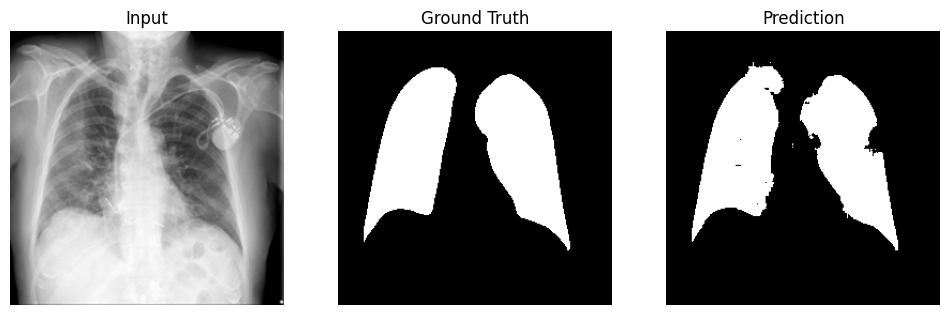

In [33]:
import matplotlib.pyplot as plt

imgs, masks = val_dataset[0]
preds = model.predict(imgs, verbose=0)

idx = 0

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Input")
plt.imshow(imgs[idx].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(masks[idx].squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow((preds[idx] > 0.5).squeeze(), cmap="gray")
plt.axis("off")

plt.show()
